In [1]:
#!usr/bin/python

""" Imports and plots the E values for the simulated vs. actual 
    ecosystem data. Also looks at the frequency distributions 
    of the E values in both simulated and actual fitted results."""

__author__ = 'Katie Hindson (kah15@ic.ac.uk)'
__version__ = '0.0.1'
		
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.patches as mpatches
from pylab import *
from scipy.optimize import curve_fit
import random
%matplotlib inline

## Building a data frame with simulation having temp range w.r.t. abs. lat. and the actual fluxnet fit results 

In [2]:
actual_df = pd.read_csv("../Results/median_temps/sites_boltz_fit_median_temps_only_results.csv")
fluxnet_df = pd.read_pickle("../Data/median_temps/fluxnet_median_temps_only.pkl")

# sorting into ascending order of siteID values 
actual_df = actual_df.sort_values(by = 'site_ID', ascending = True)
fluxnet_df = fluxnet_df.sort_values(by = 'siteID', ascending = True)

# getting the temperature ranges for each site from the fluxnet data
E_actual_temp_range = np.array(fluxnet_df.groupby('siteID')['TA_F_inKelvin'].max()) - np.array(fluxnet_df.groupby('siteID')['TA_F_inKelvin'].min())

# Making a data frame of the site IDs and their corresponding E simulated and E actual.

T_range = pd.DataFrame({'siteID' : actual_df.site_ID, 
                        'lat': actual_df.lat, 
                        'actual_temp_range' : E_actual_temp_range})

# removing any values that are Nan
T_range = T_range[T_range.siteID.notnull()]

## Creating data frame from simulated results of richness + T range w.r.t. lat

In [3]:
sim_df = pd.read_csv('../Results/median_temps/lognormal_dist/richness_and_temp_wrt_lat/med_temps_NOT_CONVERTED_simulated_E_B0.csv')
sim_df_actual_temps = pd.read_csv('../Results/median_temps/lognormal_dist/richness_and_temp_wrt_lat/ACTUAL_TEMPS_med_temps_NOT_CONVERTED_simulated_E_B0.csv')

# sorting into ascending order of siteID values since this way the indexing of the 
# two data frames will be the same.
sim_df = sim_df.sort_values(by = 'siteID', ascending = True)
sim_df_actual_temps = sim_df_actual_temps.sort_values(by = 'siteID', ascending = True)

# getting the simulated E and lnB0 values as the means of the 150 iterations
E_sim_mean = sim_df.groupby('siteID')['E'].mean().tolist()
E_sim_median = sim_df.groupby('siteID')['E'].median().tolist()
E_sim_mean_actual_temps = sim_df_actual_temps.groupby('siteID')['E'].mean().tolist()

# Making a data frame of the site IDs and their corresponding E simulated and E actual.

E_vals = pd.DataFrame({'siteID' : actual_df.site_ID, 'E_sim_mean' : E_sim_mean,
                       'E_sim_median' : E_sim_median, 'E_actual' : actual_df.E,
                      'E_sim_mean_actual_temps' : E_sim_mean_actual_temps})

# removing any values that are Nan
E_vals = E_vals[E_vals.siteID.notnull()]

E_vals['lat'] = T_range['lat']
E_vals['actual_temp_range'] = T_range['actual_temp_range']

E_vals = E_vals[E_vals.E_sim_mean.notnull()]
E_vals = E_vals[E_vals.E_sim_median.notnull()]
E_vals = E_vals[E_vals.E_sim_mean_actual_temps.notnull()]
E_vals = E_vals[E_vals.E_actual.notnull()]
E_vals = E_vals[E_vals.E_sim_mean != -np.inf]
E_vals = E_vals[(E_vals.E_actual > 0) & (E_vals.E_actual < 2)]

## Adding variance in Es to df

In [4]:
E_vals['abs_lat'] = np.abs(np.round(E_vals.lat, 0))
E_vals['lat_range'] = [np.nan] * len(E_vals.abs_lat)
E_vals['var_E'] = [np.nan] * len(E_vals.abs_lat)
E_vals['var_E_actual'] = [np.nan] * len(E_vals.abs_lat)

E_vals = E_vals.sort_values(by = 'abs_lat', ascending = True)
E_vals = E_vals.reset_index(drop = True)

lat_bins = []

i = 0
while i < len(E_vals.abs_lat):
    # if there are still 10 observations left in the dataset, do this
    if i <= (len(E_vals.abs_lat) - 25):
        # adding the latitudinal range to the subset of entries
        E_vals.lat_range.iloc[i : i + 25] = [str(int(min(E_vals.abs_lat.iloc[i:i+25]))) + '-' + 
                                             str(int(max(E_vals.abs_lat.iloc[i:i+25])))] * len(E_vals.abs_lat.iloc[i:i+25])
        # adding the simulated variance in E to the subset of entries
        E_vals.var_E.iloc[i:i+25] = np.var(np.array(E_vals.E_sim_mean.iloc[i:i+25])) * len(E_vals.abs_lat.iloc[i:i+25])
        
        # adding the variance in E from the actual data to the subset of entries
        E_vals.var_E_actual.iloc[i:i+25] = np.var(np.array(E_vals.E_actual.iloc[i:i+25])) * len(E_vals.abs_lat.iloc[i:i+25])
        
        lat_bins.append(max(E_vals.abs_lat.iloc[i:i+25]) - min(E_vals.abs_lat.iloc[i:i+25]))
        
    # otherwise, just use the rest of the observations in the data and do the 
    # same thing as above
    else:
        # getting the number of observations remaining
        length = len(E_vals.abs_lat) - i
        # adding the latitudinal range to the subset of entries
        E_vals.lat_range.iloc[i:i + length] = [str(int(min(E_vals.abs_lat.iloc[i:i+length]))) + '-' + 
                                                 str(int(max(E_vals.abs_lat.iloc[i:i+length])))] * len(E_vals.abs_lat.iloc[i:i+length])
        # adding the simulated variance in E to the subset of entries
        E_vals.var_E.iloc[i:i+length] = np.var(np.array(E_vals.E_sim_mean.iloc[i:i + length])) * len(E_vals.abs_lat.iloc[i:i+length])
        
        # adding the variance in E from the actual data to the subset of entries
        E_vals.var_E_actual.iloc[i:i+length] = np.var(np.array(E_vals.E_actual.iloc[i:i + length])) * len(E_vals.abs_lat.iloc[i:i+length])
   
        lat_bins.append(max(E_vals.abs_lat.iloc[i:i+25]) - min(E_vals.abs_lat.iloc[i:i+25]))

    i = i + 25

lat_bins = np.array(lat_bins)

/home/cmee10/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Actual data E values and their variance vs. absolute latitude

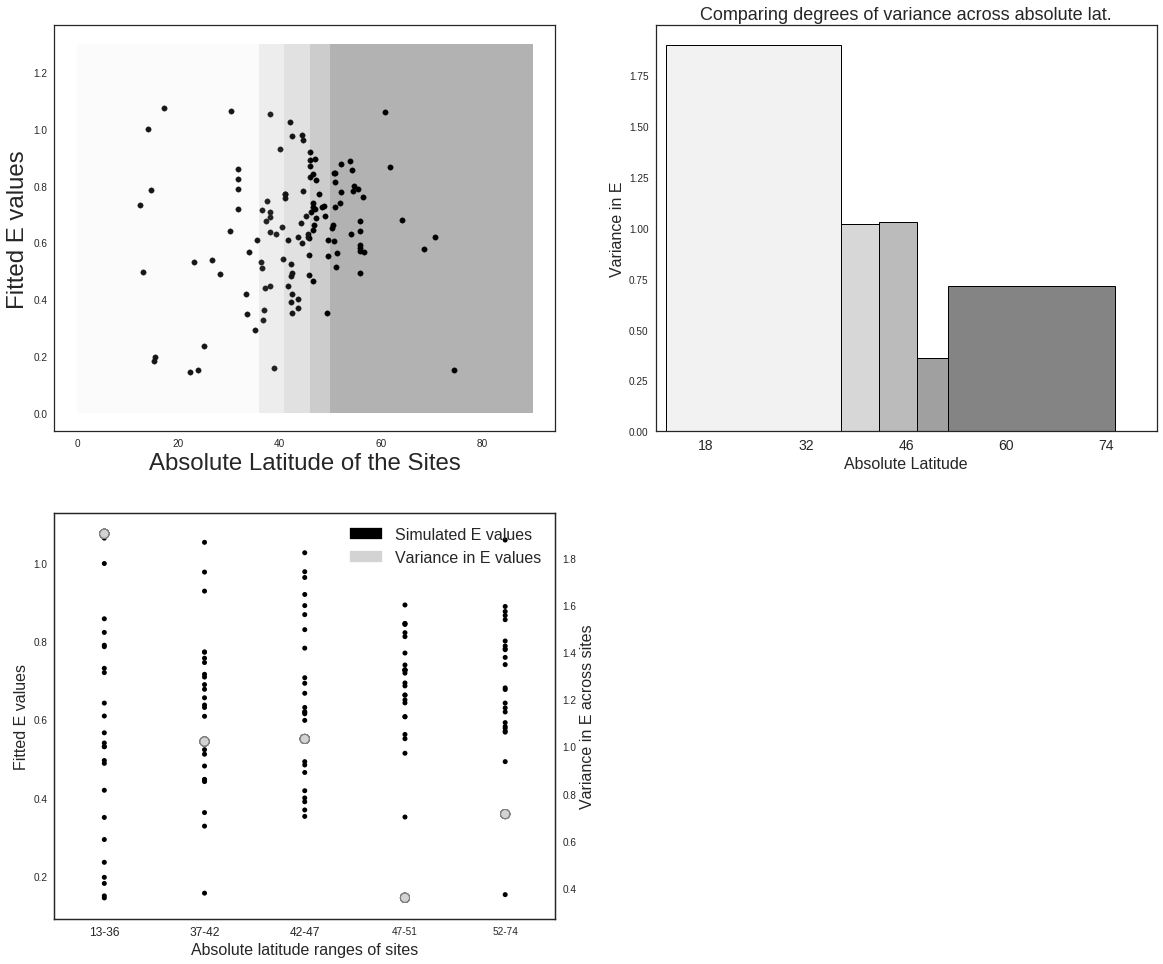

In [5]:
E_vals = E_vals.sort_values(by = 'lat_range', ascending = True)

boundaries = [0, lat_bins[0] + 13, lat_bins[0] + 13 + lat_bins[1], lat_bins[0] + 13 + lat_bins[1] + lat_bins[2], 
                    lat_bins[0] + 13 + lat_bins[1] + lat_bins[2] + lat_bins[3], 90]

with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize = (16, 13))
    fig.tight_layout()

    ax1 = plt.subplot(2, 2, 1)
    plt.fill([boundaries[0], boundaries[1], boundaries[1], boundaries[0]], [0, 0, 1.3, 1.3], 
             'gainsboro', alpha = 0.1)
    plt.fill([boundaries[1], boundaries[2], boundaries[2], boundaries[1]], 
             [0, 0, 1.3, 1.3], 'darkgray', alpha = 0.2)
    plt.fill([boundaries[2], boundaries[3], boundaries[3], boundaries[2]], 
             [0, 0, 1.3, 1.3], 'dimgray', alpha = 0.2)
    plt.fill([boundaries[3], boundaries[4], boundaries[4], boundaries[3]], 
             [0, 0, 1.3, 1.3], 'black', alpha = 0.2)
    plt.fill([boundaries[4], boundaries[5], boundaries[5], boundaries[4]], [0, 0, 1.3, 1.3], 
             'black', alpha = 0.3)
    plt.scatter(np.abs(E_vals.lat), E_vals.E_actual, color = 'black', s = 30)
    #plt.title('Comparing Actual E values against absolute lat.', 
     #         fontsize = 18)
    plt.xlabel('Absolute Latitude of the Sites', fontsize = 24)
    plt.ylabel('Fitted E values', fontsize = 24)
    low_lat = mpatches.Patch(color='gainsboro', alpha = 0.2, label='Tropical Lats')
    mid_lat = mpatches.Patch(color = 'darkgray', alpha = 0.2, label = 'Mid Lats')
    upper_lat = mpatches.Patch(color = 'dimgray', alpha = 0.2, label = 'Upper Lats')
    #plt.legend(bbox_to_anchor=(-0.1, 1.0), handles=[low_lat, mid_lat, upper_lat])

    ax2 = plt.subplot(2, 2, 2)
    pal = sns.light_palette("dimgray")
    ax2 = sns.barplot(x = E_vals.lat_range, y = E_vals.var_E_actual, palette = pal, linewidth = 1, edgecolor = 'black')
    ax2.set_title('Comparing degrees of variance across absolute lat.', fontsize = 18)
    ax2.set_ylabel('Variance in E', fontsize = 16)
    ax2.set_xlabel('Absolute Latitude', fontsize = 16)
    ax2.set_xticklabels(pd.Series.unique(E_vals.lat_range).tolist(),fontsize = 14)
    
     # Set these based on your column counts
    max_val = max(lat_bins)
    diffs = lat_bins - max_val
    diffs_prop = diffs/max_val
    new_lat_bins = np.array([100]*len(lat_bins)) + diffs_prop*100
    columncounts = new_lat_bins

    # Maximum bar width is 1. Normalise counts to be in the interval 0-1. Need to supply a maximum possible count here as maxwidth
    def normaliseCounts(widths,maxwidth):
        widths = np.array(widths)/float(maxwidth)
        return widths

    widthbars = normaliseCounts(columncounts,100)

    # Loop over the bars, and adjust the width (and position, to keep the bar centred)
    i = 0
    for bar,newwidth in zip(ax2.patches,widthbars):
        if i == 0:
            x = bar.get_x()
            prev_x = x + newwidth*1.75
            width = bar.get_width()
            centre = x + newwidth*1.75/2
            
        else:
            x = prev_x + newwidth*1.75
            prev_x = x
            centre = x-newwidth*1.75/2.
        width = bar.get_width()
                
        
        
        bar.set_x(centre-newwidth*1.75/2.)
        bar.set_width(newwidth*1.75)
        i += 1
    ax2.set_xticklabels((np.array(range(0, 90))*(74/5) + 18).astype('int'),fontsize = 14)

    ax3 = plt.subplot(2, 2, 3)
    sns.stripplot(E_vals.lat_range, E_vals.E_actual, color = 'black', label = 'E values')
    ax3.set_xlabel('Absolute latitude ranges of sites', fontsize = 16)
    ax3.set_xticklabels(['0-30 (Tropical Lat)','31-60 (Mid Lat)', '61-90 (Upper Lat)'],fontsize = 12)
    ax3.set_ylabel('Fitted E values', fontsize = 16)
    #ax3.set_title('Randomly sampled same number of sites \nfrom Mid lat and Tropical lat',
             #    fontsize = 18)
    ax4 = ax3.twinx()
    sns.stripplot(E_vals.lat_range, E_vals.var_E_actual, color = 'lightgrey', size = 9, linewidth = 1)
    ax4.set_ylabel('Variance in E across sites', fontsize = 16)

    blue_patch = mpatches.Patch(color='black', label='Simulated E values')
    black_patch = mpatches.Patch(color = 'lightgrey', label = 'Variance in E values')
    plt.legend(handles=[blue_patch, black_patch], fontsize = 16)
    

## Simulated Es vs. absolute latitude

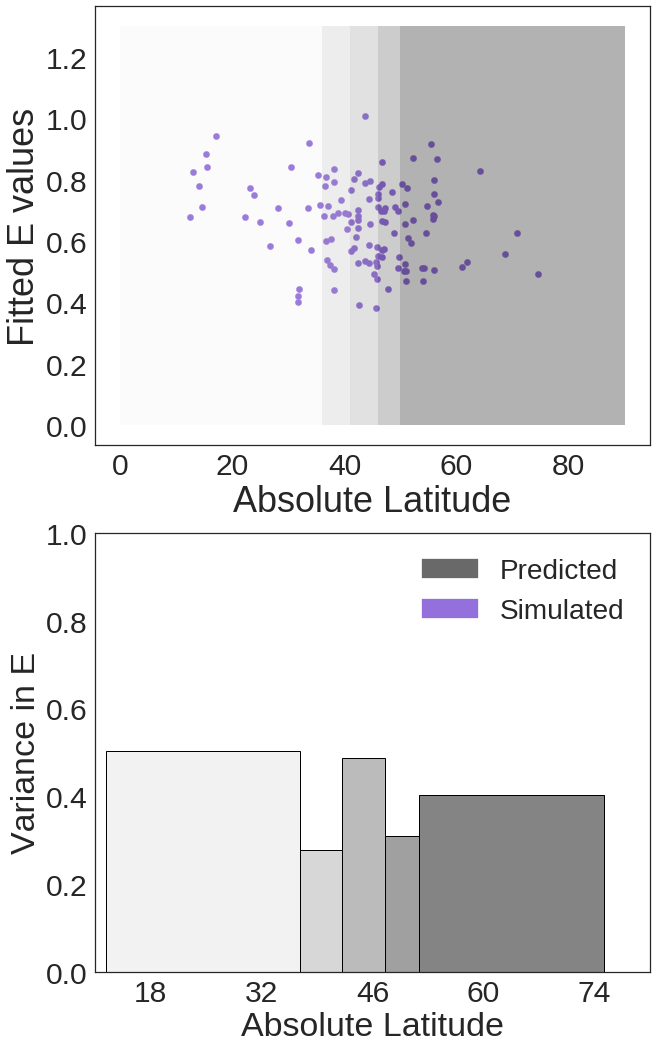

In [6]:
fig, ax = plt.subplots(figsize = (8.4, 14))
fig.tight_layout()

with plt.style.context("seaborn-white"):
    paper_rc = {'lines.linewidth': 3, 'lines.markersize': 5}            
    sns.set(font_scale=3, style = 'white', rc = paper_rc) 
    ax1 = plt.subplot(2, 1, 1)
    plt.fill([boundaries[0], boundaries[1], boundaries[1], boundaries[0]], [0, 0, 1.3, 1.3], 
             'gainsboro', alpha = 0.1)
    plt.fill([boundaries[1], boundaries[2], boundaries[2], boundaries[1]], 
             [0, 0, 1.3, 1.3], 'darkgray', alpha = 0.2)
    plt.fill([boundaries[2], boundaries[3], boundaries[3], boundaries[2]], 
             [0, 0, 1.3, 1.3], 'dimgray', alpha = 0.2)
    plt.fill([boundaries[3], boundaries[4], boundaries[4], boundaries[3]], 
             [0, 0, 1.3, 1.3], 'black', alpha = 0.2)
    plt.fill([boundaries[4], boundaries[5], boundaries[5], boundaries[4]], [0, 0, 1.3, 1.3], 
             'black', alpha = 0.3)
    plt.scatter(np.abs(E_vals.lat), E_vals.E_sim_mean, color = 'mediumpurple', s = 40, alpha = 1)    #plt.title('Comparing fitted E values against absolute lat. \nin simulation with richness as a function of abs. lat.', 
             # fontsize = 18)
    plt.xlabel('Absolute Latitude', fontsize = 36)
    plt.ylabel('Fitted E values', fontsize = 36)

    ax2 = plt.subplot(2, 1, 2)
    pal = sns.light_palette("dimgray")
    sns.barplot(x = E_vals.lat_range, y = E_vals.var_E, palette = pal, linewidth = 1, edgecolor = 'black')
    ax2.set_ylabel('Variance in E', fontsize = 34)
    ax2.set_xlabel('Absolute Latitude', fontsize = 34)
    ax2.set_xticklabels(pd.Series.unique(E_vals.lat_range).tolist(),fontsize = 30)
    
     # Set these based on your column counts
    max_val = max(lat_bins)
    diffs = lat_bins - max_val
    diffs_prop = diffs/max_val
    new_lat_bins = np.array([100]*len(lat_bins)) + diffs_prop*100
    columncounts = new_lat_bins

    # Maximum bar width is 1. Normalise counts to be in the interval 0-1. Need to supply a maximum possible count here as maxwidth
    def normaliseCounts(widths,maxwidth):
        widths = np.array(widths)/float(maxwidth)
        return widths

    widthbars = normaliseCounts(columncounts,100)

    # Loop over the bars, and adjust the width (and position, to keep the bar centred)
    i = 0
    for bar,newwidth in zip(ax2.patches,widthbars):
        if i == 0:
            x = bar.get_x()
            prev_x = x + newwidth*1.75
            width = bar.get_width()
            centre = x + newwidth*1.75/2
            
        else:
            x = prev_x + newwidth*1.75
            prev_x = x
            centre = x-newwidth*1.75/2.
        width = bar.get_width()
                
        
        
        bar.set_x(centre-newwidth*1.75/2.)
        bar.set_width(newwidth*1.75)
        i += 1
    ax2.set_xticklabels((np.array(range(0, 90))*(74/5) + 18).astype('int'),fontsize = 30)
    ax2.set_ylim(0,1)
    
    grey_patch = mpatches.Patch(label='Predicted', color = 'dimgray')
    blue_patch = mpatches.Patch(color = 'mediumpurple', label = 'Simulated')
    ax2.legend(handles = [grey_patch, blue_patch], bbox_to_anchor = (1, 1), fontsize = 28)

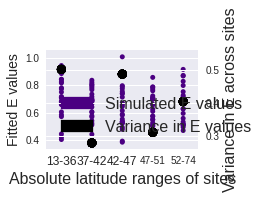

In [7]:
    ax3 = plt.subplot(2, 2, 3)
    sns.stripplot(E_vals.lat_range, E_vals.E_sim_mean, color = 'indigo', label = 'E values')
    ax3.set_xlabel('Absolute latitude ranges of sites', fontsize = 16)
    ax3.set_xticklabels(['0-30 (Tropical Lat)','31-60 (Mid Lat)', '61-90 (Upper Lat)'],fontsize = 12)
    ax3.set_ylabel('Fitted E values', fontsize = 14)
    #ax3.set_title('Randomly sampled same number of sites \nfrom Mid lat and Tropical lat',
     #            fontsize = 18)
    ax4 = ax3.twinx()
    sns.stripplot(E_vals.lat_range, E_vals.var_E, color = 'black', size = 9)
    ax4.set_ylabel('Variance in E across sites', fontsize = 16)

    blue_patch = mpatches.Patch(color='indigo', label='Simulated E values')
    black_patch = mpatches.Patch(color = 'black', label = 'Variance in E values')
    plt.legend(handles=[blue_patch, black_patch], fontsize = 16)

(0, 1)

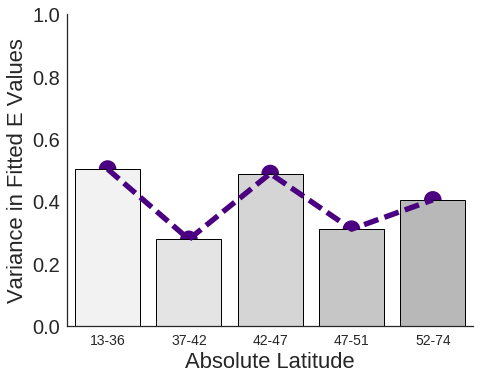

In [8]:
pal = sns.light_palette("darkgray")
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 5}            
sns.set(font_scale=2, style = 'white', rc = paper_rc) 
ax2 = sns.FacetGrid(E_vals, size = 6, aspect = 1)
ax2 = ax2.map(sns.barplot, 'lat_range', 'var_E', palette = pal, linewidth = 1, edgecolor = 'black')
ax2 = ax2.map(sns.pointplot,  'lat_range', 'var_E', color = 'indigo', linestyles = 'dashed')
ax2.set_axis_labels("Absolute Latitude","Variance in Fitted E Values")
plt.subplots_adjust(top=0.9, left = -0.001)
#ax2.fig.suptitle('Comparing variance across absolute latitude')
ax2.set_xticklabels(pd.Series.unique(E_vals.lat_range).tolist(),fontsize = 14)
axes = ax2.axes
axes[0,0].set_ylim(0,1)

## Running a Bartlett's test for homogeneity of variance across the three latitudinal groups

In [9]:
lat_ranges = list(pd.Series.unique(E_vals.lat_range))

zer_one = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[0], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[1], 'E_sim_mean'])
print('zer_one: ' + str(zer_one))

zer_two = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[0], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[2], 'E_sim_mean'])
print('zer_two: ' + str(zer_two))

zer_three = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[0], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[3], 'E_sim_mean'])
print('zer_three: ' + str(zer_three))

zer_four= stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[0], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[4], 'E_sim_mean'])
print('zer_four' + str(zer_four))

one_two = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[1], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[2], 'E_sim_mean'])
print('one_two' + str(one_two))

one_three = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[1], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[3], 'E_sim_mean'])
print('one_three' + str(one_three))

one_four = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[1], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[4], 'E_sim_mean'])
print('one_four' + str(one_four))

two_three = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[2], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[3], 'E_sim_mean'])
print('two_three' + str(two_three))

two_four = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[2], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[4], 'E_sim_mean'])
print('two_four' + str(two_four))

three_four = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[3], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[4], 'E_sim_mean'])
print('three_four' + str(three_four))

zer_one: BartlettResult(statistic=2.0500390898571323, pvalue=0.15220228192656057)
zer_two: BartlettResult(statistic=0.0049404160421805243, pvalue=0.94396435933797651)
zer_three: BartlettResult(statistic=1.3624112185230306, pvalue=0.24312003315483277)
zer_fourBartlettResult(statistic=0.097486861048438622, pvalue=0.75486660051669363)
one_twoBartlettResult(statistic=1.8576088491735838, pvalue=0.17290102718989941)
one_threeBartlettResult(statistic=0.072514135514777492, pvalue=0.78771076817856522)
one_fourBartlettResult(statistic=1.2012540627537738, pvalue=0.27307117556235083)
two_threeBartlettResult(statistic=1.205346207413919, pvalue=0.27225575602051078)
two_fourBartlettResult(statistic=0.059386139147665808, pvalue=0.80746881620879418)
three_fourBartlettResult(statistic=0.69536839277593476, pvalue=0.40434437157185743)


## Running Bartlett's to compare simulated and actual in each latitude bin

In [11]:
zer = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[0], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[0], 'E_actual'])
print('zer: ' + str(zer))

one = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[1], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[1], 'E_actual'])
print('one: ' + str(one))

two = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[2], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[2], 'E_actual'])
print('two: ' + str(two))

three = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[3], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[3], 'E_actual'])
print('three: ' + str(three))

four = stats.bartlett(E_vals.loc[E_vals.lat_range == lat_ranges[4], 'E_sim_mean'], 
                   E_vals.loc[E_vals.lat_range == lat_ranges[4], 'E_actual'])
print('four: ' + str(four))


zer: BartlettResult(statistic=9.7159429921635745, pvalue=0.0018267632409077923)
one: BartlettResult(statistic=9.3557246356579213, pvalue=0.0022229006440666354)
two: BartlettResult(statistic=3.2201599407115249, pvalue=0.072736522715496396)
three: BartlettResult(statistic=0.12999709546060406, pvalue=0.71843505045467315)
four: BartlettResult(statistic=1.7249278581283736, pvalue=0.18905995525422303)
